# Exercise 1b

## Fundamentals of Machine Learning

#### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl

#### Version information:
        2020-11-27: v.1.0. First public release. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time

## 3 - Nearest Neighbor Classification on Real Data

### 3.1 - Exploring the Data (3 pts)

<span style="color:green;font-weight:bold">This part is essentially the same code as the supplied sample solution. The digits data is explored and a number is graphed.</span>

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data         = digits["data"]
images       = digits["images"]
target       = digits["target"]
target_names = digits["target_names"]

print(data.dtype)
print(data.shape)
print(images.shape)
print(images[3].shape)
print(target.shape)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
float64
(1797, 64)
(1797, 8, 8)
(8, 8)
(1797,)


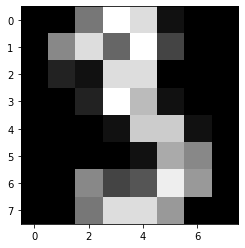

In [3]:
img = images[3]
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img,interpolation="nearest",) # also try interpolation="bicubic"
plt.show()

In [4]:
from sklearn import model_selection

X_all = data
y_all = target

X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data,digits.target,test_size=0.4,random_state=0)

### 3.2 - Distance function computation using loops (3 pts) 

<span style="color:green;font-weight:bold">Our implementation of the distance function using loops is (on purpose) even worse than the sample implementation, since it uses one additional for-loop to go through each pixel value in the images. Another difference is that we assert that the two input matricies are compatible. The sample solution is very compact, but I do however prefer our own code from a readabilty standpoint. The definition of the variables M,N,D for matrix sizes might not be needed, but definitely helps to making the code easier to overview.</span>

In [5]:
def dist_loops(training, test):
    """
    Calculate the euclidean distances between all instances in the training and the test sets
    in the feature space, using for-loops.
    
    params
    ------
    training: np.array
        Matrix of size (N,D), where N number of instances, D number of pixels in each image.
    test: np.array
        Matrix of size (M,D), where M number of instances, D number of pixels in each image.

    returns
    -------
    np.array shape=(N,M)
        Euclidean distances from each training instance to each test instance.
    """
    # Find sizes of matrices.
    N,D1 = training.shape
    M,D2 = test.shape

    # Assure that sizes match.
    assert D1 == D2
    D = D1

    # Preallocation
    dist = np.zeros((M,N))
    
    # for each image in test set
    for i in range(M):
        # for each image in training set
        for j in range(N): 
            # for each pixel in image, calculate the euclidean distance.
            d = 0
            for k in range(D): 
                d = d + (test[i,k]-training[j,k])**2
            d = np.sqrt(d)
            # Put value in distance matrix
            dist[i,j] = d
    return dist

### 3.3 - Distance function computation using vectorization (8 pts)

<span style="color:green;font-weight:bold"> Our vectorization could have been better, since using np.tile() is probably less efficient than broadcasting. Have learned now, and will use it for future implementations. However, this is a working implementation and produced reasonably fast results. Would have been cool to make an implementation using the alternate approach to vectorization showed in the sample solution, however I personally would never have though of this by myself. Really cool solution though.</span>

In [6]:
def dist_vec(training, test):
    """
    Calculate the euclidean distances between all instances in the training and the test sets
    in the feature space, using vectorization.
    
    params
    ------
    training: np.array
        Matrix of size (N,D), where N number of instances, D number of pixels in each image.
    test: np.array
        Matrix of size (M,D), where M number of instances, D number of pixels in each image.

    returns
    -------
    np.array shape=(N,M)
        Euclidean distances from each training instance to each test instance.
    """
    # Find the sizes of the matrices.
    N,D1 = training.shape
    M,D2 = test.shape

    # Assure that the sizes along the D-axis match.
    assert D1 == D2
    D = D1
    
    # Stack N or M clones of each 2d matrix into the third dimension.
    training_3d = np.tile(training,(M,1,1))     # 3d-matrix with dimensions (M,N,D)
    test_3d = np.tile(test, (N,1,1))            # 3d-matrix with dimensions (N,M,D)

    # Swap axes so dimensions match (M,N,D)
    test_3d = np.swapaxes(test_3d,0,1)

    # Subtract the two 3d matricies elementwise, square elementwise, sum along the D-axis and  
    # finish with the elementwise square root. Thus we have the euclidian distance matrix.
    dist = np.sqrt(np.sum((test_3d-training_3d)**2, axis=2))          

    return dist

<span style="color:green;font-weight:bold">Probably should have used %timeit for timing instead of the current approach, didn't realise that way was that different and better than the normal time module. Ah well. Not sure if this is uncommon or not, but for our implementation, the function np.array_equal() outputs True when comparing the two distance matricies. This was not the case in the sample solution, so I'm not sure if this is a fault or not, and if it is on our side or not.</span>

In [7]:
# Time the executions for both functions, and assure that both produce the same result.
tik = time.time()
A1 = dist_loops(X_train,X_test)
tok = time.time()
print(f"Time elapsed for dist_loops(): {tok-tik:.2f} s")

tik = time.time()
A2 = dist_vec(X_train,X_test)
tok = time.time()
print(f"Time elapsed for dist_vec(): {tok-tik:.2f} s")

assert np.array_equal(A1,A2)

Time elapsed for dist_loops(): 39.11 s
Time elapsed for dist_vec(): 0.44 s


### 3.4 - Implementation of the k-nearest neighbor classifier

<span style="color:green;font-weight:bold"> Our code is sort of similar to the sample solution, but a few things differ. While it used np.argsort(), we used np.argpartition() reaching the same results. Not sure which way is more/less efficient. And while the sample solution manually found out which class was most occuring most often, we used np.bincount() which was also suggested in the sample solution. Same thing here, not sure which method is better or worse. One benefit with the sample solution is that it ensures that the programmer truly knows what he/she is doing since it's done manually.</span>

In [8]:
def kNN_classifier(X_training, X_test, y_training, k, dist_func):
    """
    Classify M test instances X using the k-nearest neighbors algorithm, given a training set with N
    instances of feature data X in D dimensions and N corresponding labels y.

    params
    ------
    X_training: np.array
        Matrix of size (N,D), where N number of training instances, D number of pixels in 
        each image.
    X_test: np.array
        Matrix of size (M,D), where M number of test instances, D number of pixels in each image.
    y_training: np.array
        Matrix of size (N,1) with labels corresponding to the instances in X_training.
    k: int
        Number of neighbors to include in the majority vote for classification.
    dist_func: callable
        Function to calculate distances between all instances in the test and training sets.  

    returns
    -------
    np.array shape=(M,1)
        Predictions for every instance in test set, given the training set.
    """

    # Get the distance matrix.
    dist = dist_func(X_training, X_test)          # shape (M,N)

    # Get indicies of the k smallest distances for each test instance.
    ind = np.argpartition(dist, k, axis=1)[:,:k]  # shape (M,k)
    
    # Preallocation
    M = len(X_test)
    y_prediction = np.zeros(M)

    # For each test instance, get the most frequently occuring label. Choose 
    # this as our prediction y.
    for i in range(M):
        y_prediction[i] = np.bincount(y_training[ind[i,:]]).argmax()

    return y_prediction

Use the classifier to distinguish digits of 3 from digits of 9.

<span style="color:green;font-weight:bold"> I like the specific function knn_compare() that was created in the sample solution for comparision of two arbitrary classes, and which then was subsequently used to create a confusion matrix. However, our hard-coded solution for 3 and 9 is following the given specifications and is seemingly working. Our plot does not exactly align with the plot in the sample solution, but I believe that it is within the error limits of the implementations. However, we really should have plotted the specific data-points and not just the lines connecting them.</span>

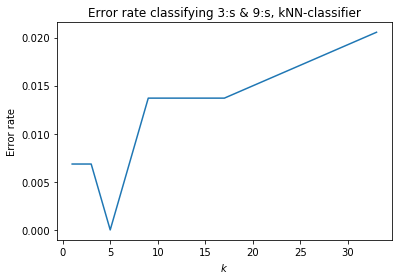

In [9]:
# Filter out threes and nines from the training and test data.
mask = (target == 3) | (target == 9)
data_filtered   = data[mask,:]
target_filtered = target[mask]

# Create training and test sets.
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_filtered,target_filtered,test_size=0.4,random_state=0)

# k-values to test.
k_list = [1,3,5,9,17,33]
error = np.zeros(len(k_list))
for i,k in enumerate(k_list):
    # Get predictions.
    y_predict = kNN_classifier(X_train, X_test, y_train, k, dist_vec)

    # Calculate the error rate.
    correct_pred = sum(y_test == y_predict)
    error[i] = 1 - correct_pred/len(y_test)

# Plot the error rate as a function of k.
plt.plot(k_list, error)
plt.xlabel('$k$')
plt.ylabel('Error rate')
plt.title('Error rate classifying 3:s & 9:s, kNN-classifier')
plt.show()

## 4 - Cross-validation

<span style="color:green;font-weight:bold">I find it a bit interesting that the sample solution does not follow the explicit instructions in the specifications to write the split_folds() function. However, our implementation to generate the folds is still worse than the sample solution, since we accompished the task in an unnecessarily complicated way, by merging the two arrays, shuffling and then splitting it up again.</span>

In [10]:
def split_folds(data, target, L):
    # Combine X and y into a single matrix.
    Xy_block = np.block([data,target[:, None]])

    # Randomly permutate the rows in-place.
    np.random.shuffle(Xy_block)

    # Separate X from y
    X_shuffled = Xy_block[:,:-1]
    y_shuffled = Xy_block[:,-1]

    # Force typecast of y back to 'int64'
    y_shuffled = y_shuffled.astype(int)

    # Split each array into L folds.
    X_folds = np.array_split(X_shuffled, L, axis=0)
    y_folds = np.array_split(y_shuffled, L)

    return X_folds, y_folds 

<span style="color:green;font-weight:bold">The comparison of our kNN classifier and sklearn's is done in mostly the same way as it's done in the sample solution. Perhaps not as short in line-count, and not as fancy of a presentation as using pandas, but otherwise it's essentially the same. </span>

In [11]:
from sklearn.neighbors import KNeighborsClassifier

# Values of k and L to perform cross-validation for.
k_list = [1,5]
L_list = [2,5,10]

print('k-NN classification comparison between our implementation and sklearn\'s.')
print('Cross-validation over L folds, for each value of k.\n')

# For each combination of values in k_list and L_list.
for idx_k, k in enumerate(k_list):

    # Initialize sklearn's k-NN classifier for current value of k.
    neigh = KNeighborsClassifier(n_neighbors=k)

    for idx_L, L in enumerate(L_list):
        # Generate the folds randomly.
        X_folds, y_folds = split_folds(X_all, y_all, L)
        
        # Preallocation
        error = np.zeros(L)
        error_sklearn = np.zeros(L)

        # Perform the cross-validation.
        for i in range(L):
            # Combine folds into the current training and test sets.
            # First, the test folds, easy to assign to a single matrix.
            X_test  = X_folds[i]
            y_test  = y_folds[i]
            
            # Second, the training folds. Need to filter out the i:th list item.
            X_folds_without_i = [x for idx,x in enumerate(X_folds) if idx!=i]
            y_folds_without_i = [x for idx,x in enumerate(y_folds) if idx!=i]
            
            # Then concatenate the remaining list items into a single matrix.
            X_train = np.concatenate(X_folds_without_i, axis=0)
            y_train = np.concatenate(y_folds_without_i)

            # Get the predictions using our k-NN algorithm.
            y_predict = np.zeros_like(y_test)
            y_predict = kNN_classifier(X_train, X_test, y_train, k, dist_vec)

            # Get the predictions using sklearn:s k-NN algorithm.
            neigh.fit(X_train, y_train)
            y_predict_sklearn = neigh.predict(X_test)
            
            # Calculate the error rates.
            correct_pred = sum(y_test == y_predict)
            error[i] = 1 - correct_pred/len(y_test)

            correct_pred_sklearn = sum(y_test == y_predict_sklearn)
            error_sklearn[i] = 1 - correct_pred_sklearn/len(y_test)

        # Calculate the mean error rates and standard deviations
        mean_error_rate = np.average(error)
        std_error_rate = np.std(error)

        mean_error_rate_sklearn = np.average(error_sklearn)
        std_error_rate_sklearn = np.std(error_sklearn)

        # Print the results
        print(f'k = {k}, L = {L}')
        print(f'    Our classifier:        avg error = {mean_error_rate:<7.4}, std error = {std_error_rate:.4}')
        print(f'    Sklearn\'s classifier:  avg error = {mean_error_rate_sklearn:<7.4}, std error = {std_error_rate_sklearn:.4}\n')

k-NN classification comparison between our implementation and sklearn's.
Cross-validation over L folds, for each value of k.

k = 1, L = 2
    Our classifier:        avg error = 0.01503, std error = 0.003904
    Sklearn's classifier:  avg error = 0.01503, std error = 0.003904

k = 1, L = 5
    Our classifier:        avg error = 0.0128 , std error = 0.003338
    Sklearn's classifier:  avg error = 0.0128 , std error = 0.003338

k = 1, L = 10
    Our classifier:        avg error = 0.01224, std error = 0.008173
    Sklearn's classifier:  avg error = 0.01224, std error = 0.008173

k = 5, L = 2
    Our classifier:        avg error = 0.0217 , std error = 0.0005444
    Sklearn's classifier:  avg error = 0.0217 , std error = 0.0005444

k = 5, L = 5
    Our classifier:        avg error = 0.01447, std error = 0.008879
    Sklearn's classifier:  avg error = 0.01447, std error = 0.008879

k = 5, L = 10
    Our classifier:        avg error = 0.0128 , std error = 0.007487
    Sklearn's classifier:  a

<span style="color:green;font-weight:bold">Similarly to the sample solution, we did also get the same results as SKlearn's implementation for our own implementation. However, we only did one run for each value of k and foldcount, while the sample solution averaged over 20 repetitions for each combination of parameters. This is objectively the better way of doing it, but since it was not explicitly mentioned in the specifications, I don't believe we're at fault for not doing it. But of course, that is a better way of truthfully representing the performance of the classifier. I believe this is also the reason why our results differ so much form the sample solution's results. If we would have done the error rates as averages over multiple repetitions, the error would most likley approach the ones in the sample solution, since right now, our errors are rather dependent on the specfic way that the data is shuffled and split into folds. </span>